кому надо тестовую выборку можно скачать вот таким кодом: import yfinance as yf
data = yf.download('TSLA','2020-09-25','2021-01-25',interval='1h')
test_dataset=pd.DataFrame(data.reset_index(),columns=['Open', 'High', 'Low', 'Close','Volume'])


## Загрузка

In [ ]:
import importlib.util, sys, gdown

In [ ]:
url = 'https://storage.googleapis.com/aiu_bucket/data.zip'
output = 'data.zip' # Указываем имя файла, в который сохраняем файл
gdown.download(url, output, quiet=True) # Скачиваем файл по указанному URL

'data.zip'

In [ ]:
!unzip -q data.zip -d ''

## Основной блок

In [ ]:
import utils # Подключаем набор функций

**Загрузка данных**

In [ ]:
train_dataset, val_dataset = utils.getData() # Загружаем обучающий и проверочный датасет

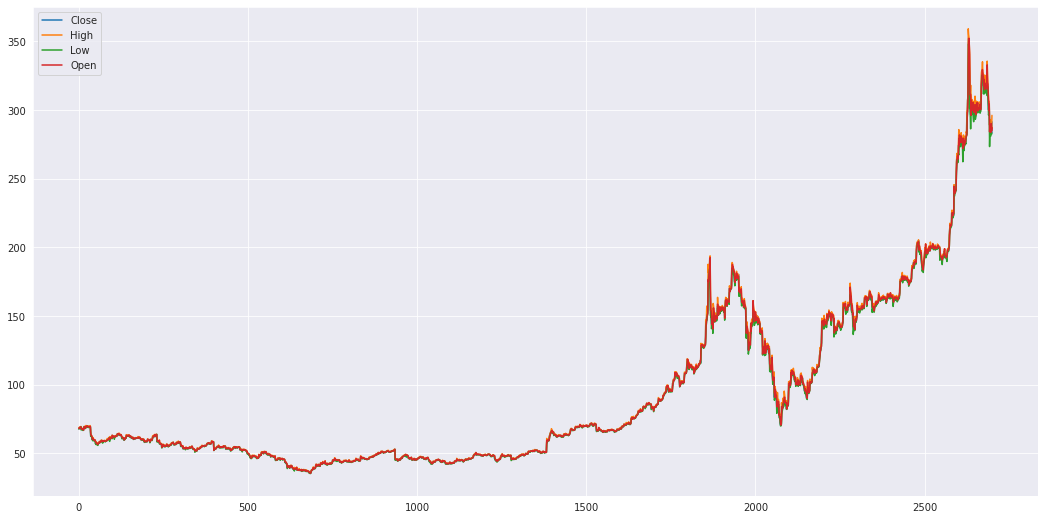

In [ ]:
utils.show_data(train_dataset, start=0, end=0, param=['Close','High','Low','Open']) # Визуализируем обучающий датасет

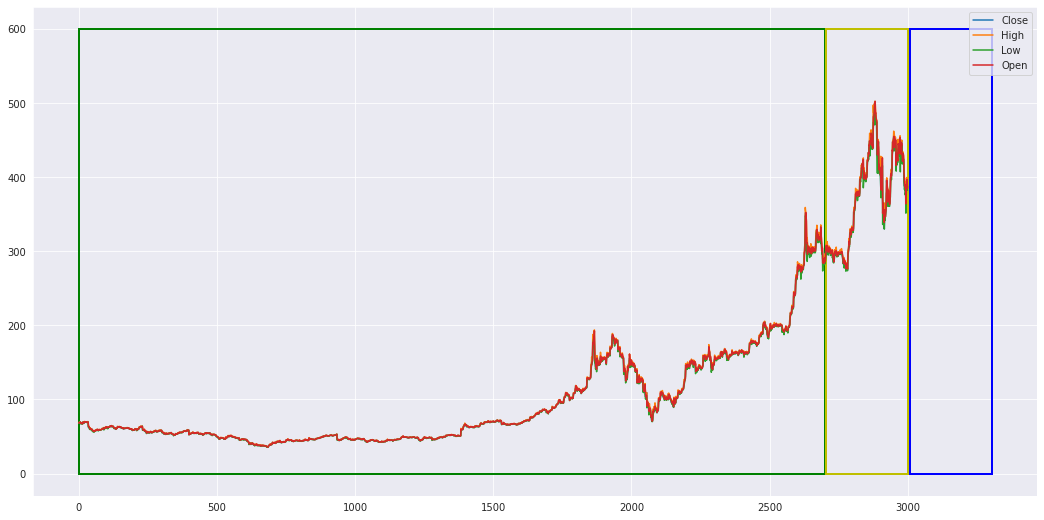

In [ ]:
utils.show_full_data(train_dataset, val_dataset,param=['Close','High','Low','Open'])

### **Блок создания нейронной сети**

#### **1. Подготовка данных**

In [ ]:
# импорт библиотек
import numpy as np #Библиотека работы с массивами
import pandas as pd #Библиотека работы с массивами

from tensorflow.keras.models import Sequential #Сеть прямого распространения
from tensorflow.keras.layers import concatenate, Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, RMSprop # оптимизаторы

import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

Проверяется следующая стратегия:

1. Вычисляем моменты сделок в обучающей последовательности. Расчитываем размер доходности каждой сделки.
2. Тренируем сеть предсказывать моменты сделок приносящих доход.

In [ ]:
###########################
# функция для подготовки массива с расчетной доходностью и направлением сделки (+/-/0) 
##########################

def calc_y(dataset):  #на вход подается массив с ценой закрытия 
  y_data = pd.DataFrame(dataset.iloc[:]['Close'])
  d_cost, Y1 = [0], [0.0]  #в список будет добавлена производная цен и произведение производных (если произведение отрицательно, значит смена направления цены и должны быть сделка) 
  for i in range(1, len(y_data)):
    d_cost.append(y_data.iloc[i]['Close']-y_data.iloc[i-1]['Close'])
  y_data['Diff'] = d_cost #добавляем столбец с разницей цен

  [Y1.append(d_cost[i]*d_cost[i+1]) for i in range(1, len(d_cost)-1)] #произведение на будущий diff, как признак изменения направления
  Y1.append(0.0)
  y_data['Y1'] = Y1

  Y2 = list(map(lambda x: x * (x<0), Y1)) #только отрицательные, остальное нули
  y_data['Y2'] = Y2

  Y3 = np.array(Y2) * np.sign(d_cost)
  y_data['Y3'] = Y3

  tmp_i = 0 #период между сделками, влияет на доходность
  Profit = []  #здесь будет рассчитанная доходность
  for i in range(len(d_cost)): #
    if Y3[i]:
      Profit.append((y_data.iloc[i]['Close']-y_data.iloc[tmp_i]['Close'])/(y_data.iloc[tmp_i]['Close'] + (d_cost[i] * (d_cost[i]<0)))/(tmp_i-i)*100)
      tmp_i = i
      # print(i, Profit[i]*100, (d_cost[i] * (d_cost[i]<0)))
    else:
      Profit.append(0.0)
  y_data['Profit'] = Profit
  return y_data    

dataset_train = train_dataset.copy()  #датасет с обучающими данными
dataset_test = val_dataset.copy()     #датасет с проверочными данными

y_data = calc_y(dataset_train)

calc_y(dataset_train)[-5:]

,Close,Diff,Y1,Y2,Y3,Profit
2695,283.970001,-2.732788,-16.828480,-16.828480,16.828480,0.912846
2696,290.127991,6.157990,-34.349283,-34.349283,-34.349283,-2.168535
2697,284.549988,-5.578003,8.021103,0.000000,-0.000000,0.000000
2698,283.112000,-1.437988,-11.771379,-11.771379,11.771379,1.215143
2699,291.298004,8.186005,0.000000,0.000000,0.000000,0.000000


In [ ]:
###########################
# функция преобразует обучающий датасет в нормированную последовательность  
##########################

def get_sequence(data, xLen, x_fit, y_fit): 
#нормирует и нарезает X последовательности длиной xLen и ставит в соответствие Y. 
#data - DataFrame с данными об акции 
#xLen - размер окна (глубина историчности)
  Y = list()  #здесь будет массив из нарезанных x_data и соответствующих y_data
  #нормируем x_data перед нарезанием

  Open = preprocessing.scale(data['Open'])
  High = preprocessing.scale(data['High'])
  Low = preprocessing.scale(data['Low'])
  Close = preprocessing.scale(data['Close'])
  Volume = preprocessing.scale(data['Volume'])
  x_data_scaled = [[Open[i]] + [High[i]] + [Low[i]] + [Close[i]] + [Volume[i]] for i in range(len(Open))]

  y_data = calc_y(data)['Profit'].to_numpy()
  y_data_scaled = y_fit.transform(y_data.reshape(-1,1)).flatten()

  for i in range(len(x_data_scaled)-xLen+1):
    Y.append(y_data_scaled[i+xLen-1]) 

  X = np.array([x_data_scaled[i:i+xLen] for i in range(len(x_data_scaled)-xLen+1)])

  return X, np.array(Y)

In [ ]:
###########################
# функция переводит часть предсказанных событий в вероятность конкретной сделки  
##########################

matr = [[0,1,0], [0,1,-1], [0,1,1], [0,0,1], 
        [0,-1,0], [0,-1,1], [0,-1,-1], [0,0,-1], 
        [1,-1,0], [-1,1,0], [-1,0,1], [1,0,-1]]

def sign(a):  #определяет знак числа или 0
  return ((a > 0) * 2 -1) * (a != 0)

def get_action_probability(xp, xo):

  tmp = [0 for i in range(len(matr))] #пустой массив-шаблон
  m_buy, m_buy_plus, m_buy_minus = tmp.copy(), tmp.copy(), tmp.copy()
  m_sale, m_sale_plus, m_sale_minus = tmp.copy(), tmp.copy(), tmp.copy()  #plus значит (min+max)/2 - среднее выше 0, minus - ниже
  m_wait, m_wait_plus, m_wait_minus = tmp.copy(), tmp.copy(), tmp.copy()
  m_corr = list() #массив корреляций. Здесь будут результаты вычесления корреляций шаблонов с предсказанными значениями

  y1 = [sign(i) for i in xo]  #список сигналов из оригинальной последовательности

  for i in range(len(xp)-len(matr[0])):
    xp_tmp = xp[i:i+len(matr[0])]
    for j, m in enumerate(matr):
      m_corr.append(np.corrcoef(np.vstack((m, xp_tmp)))[0][1])  #m_corr[0::len(matr[0])] - чтобы посмотреть корреляцию с первой матрицей
      # print(f'template {m}, check {xp_tmp}, answer {y1[i+len(m)]}',
      #       f'corr {round(m_corr[-1],4)}')
    b = m_corr[-len(matr):] #результаты корреляции с каждой матрицей
    m_id = b.index(max(b)) #индек матрицы с наибольшей корреляцией
    # print('result:', m_id, max(b), matr[b.index(max(b))], end=' - ')

    #увеличиваем счетчики для индексов соответствующего шаблона матрицы, чтобы рассчитать потом вероятность
    avrg = (max(xp_tmp) + min(xp_tmp))/2
    if y1[i+len(m)-1] < 0:  #sell
      # print('sell', max(xp_tmp), min(xp_tmp), avrg) 
      m_sale[m_id] += 1
      m_sale_plus[m_id] += 1 * avrg >= 0
      m_sale_minus[m_id] += 1 * avrg < 0

    if y1[i+len(m)-1] > 0:  #buy
      # print('buy', max(xp_tmp), min(xp_tmp), avrg) 
      m_buy[m_id] += 1
      m_buy_plus[m_id] += 1 * avrg >= 0
      m_buy_minus[m_id] += 1 * avrg < 0
    if y1[i+len(m)-1] == 0:  #wait
      # print('wait', max(xp_tmp), min(xp_tmp), avrg) 
      m_wait[m_id] += 1
      m_wait_plus[m_id] += 1 * avrg >= 0
      m_wait_minus[m_id] += 1 * avrg < 0
  
  wsb_avrg = [[m_wait[i], m_sale[i], m_buy[i]] for i in range(len(m_buy))]
  wsb_plus = [[m_wait_plus[i], m_sale_plus[i], m_buy_plus[i]] for i in range(len(m_buy_plus))]
  wsb_minus = [[m_wait_minus[i], m_sale_minus[i], m_buy_minus[i]] for i in range(len(m_buy_minus))]

  return wsb_avrg, wsb_plus, wsb_minus  #возвращает распределение вероятности для каждого типа сделки в соответствии с отдельным шаблоном. 
  # Например wsp_plus[0] = '[3,15,2]' означает max вероятность для продажи ('s'=15)

###########################
# функция предсказывает конкретную сделку на основе наибольшей вероятности  
##########################
def act_predict(v):
  v_corr = []
  for m in matr:
    v_corr.append(np.corrcoef(np.vstack((m, v)))[0][1])  #m_corr[0::len(matr[0])] - чтобы посмотреть корреляцию с первой матрицей
    m_id = v_corr.index(max(v_corr))  #индекс шаблона matr, с которым наибольшая корреляция
    avrg = (max(v)+min(v))/2
    if avrg >= 0:
      act = 'wsb'[wsb_plus[m_id].index(max(wsb_plus[m_id]))]
    else:
      act = 'wsb'[wsb_minus[m_id].index(max(wsb_minus[m_id]))]
  return act, m_id, avrg  #w - wait, s - sale, b - buy

In [ ]:
xLen = 2 #глубина исторических данных
x_scaler, y_scaler = StandardScaler(), StandardScaler(with_mean=False)  #y_scaler центрируем на 0 (with_mean=False), это важно, т.к. знак определяет тип сделки
x_fit = x_scaler.fit(dataset_train)
y_fit = y_scaler.fit(calc_y(dataset_train)['Profit'].to_numpy().reshape(-1,1))

x_train_seq, y_train_seq = get_sequence(dataset_train, xLen, x_fit, y_fit)  #обучающие данные
x_test_seq, y_test_seq = get_sequence(dataset_test, xLen, x_fit, y_fit)     #проверочные данные

#проверяем размеры и содержание
#y_train/test показывает, когда происходит разворот и в какую сторону
print('Обучающая выборка:\n', x_train_seq.shape, y_train_seq.shape)
print('\nПроверочная выборка:\n', x_test_seq.shape, y_test_seq.shape)
print()

#проверка функции обратной трансформации
n = 5  #количество выборок 
y_tmp = calc_y(dataset_train)
print('Train x y')
for i in range(n):  
  print(x_train_seq[i][-1], y_fit.inverse_transform(y_train_seq[[i]]), y_tmp['Profit'][i+xLen-1])

print()
print('Test x y')
y_tmp = calc_y(dataset_test)
for i in range(n):  
  print(x_test_seq[i][-2], y_fit.inverse_transform(y_test_seq[[i]]), y_tmp['Profit'][i+xLen-1])

Обучающая выборка:
 (2699, 2, 5) (2699,)

Проверочная выборка:
 (299, 2, 5) (299,)

Train x y
[-0.40386603 -0.39924429 -0.39591714 -0.40178016 -0.5667078 ] [0.] 0.0
[-0.40093875 -0.40193351 -0.39423205 -0.39481215 -0.73317346] [0.] 0.0
[-0.39445114 -0.39393683 -0.38639996 -0.38870174 -0.63235773] [0.] 0.0
[-0.38843604 -0.39039482 -0.3872032  -0.38495318 -0.65130088] [0.] 0.0
[-0.3853202  -0.39030094 -0.37981988 -0.38350946 -0.77166492] [0.] 0.0

Test x y
[-1.32538482 -1.32694471 -1.38229929 -1.41327893 -0.63808682] [0.] 0.0
[-1.41108253 -1.38593387 -1.41586081 -1.37640846 -0.67062903] [0.] 0.0
[-1.3724356  -1.31420639 -1.33581366 -1.27156892 -0.72183906] [0.] 0.0
[-1.26837201 -1.21548277 -1.25382864 -1.19214706 -0.54842555] [0.] 0.0
[-1.18819105 -1.10242842 -1.16277488 -1.05939357 -0.55333223] [-1.54016741] -1.5401674087585553


#### **2. Создание неросети**

In [ ]:
def plot_loss(h): #функция выводит график ошибки
  # Выводим графики ошибки
  plt.subplot(1,3,2)
  plt.plot(h.history['loss'], label='Ошибка на обучающем наборе')
  plt.plot(h.history['val_loss'], label='Ошибка на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Ошибка')
  plt.legend()
  plt.show()

In [ ]:
#пересобираем данные для нейросети
xLen = 2 #глубина исторических данных

x_train_seq, y_train_seq = get_sequence(dataset_train, xLen, x_fit, y_fit)
x_test_seq, y_test_seq = get_sequence(dataset_test, xLen, x_fit, y_fit)

###########################
# функция создания нейронной сети  
##########################

def create_model():
  modelC = Sequential()

  modelC.add(LSTM(10, input_shape = (x_train_seq.shape[1], x_train_seq.shape[2])))

  modelC.add(Dropout(0.3))
  modelC.add(BatchNormalization())

  modelC.add(Dense(1, activation='linear'))

  modelC.compile(optimizer=Adam(lr=0.001), loss='mse') #rmsprop Adam(lr=0.0001)
  return modelC

modelC = create_model2()
modelC.summary() 

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 10)                640       
_________________________________________________________________
batch_normalization_9 (Batch (None, 10)                40        
_________________________________________________________________
dropout_12 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 691
Trainable params: 671
Non-trainable params: 20
_________________________________________________________________


In [ ]:
# загружаем предобученные веса
# !!! необходимо указать актуальный путь для файла (94.95L10D0.3BND1xL2.ckpt), ниже ссылка на файл:
# https://drive.google.com/file/d/1ccprTfprMONBHngZcd3drpMqry7MNKOA/view?usp=sharing
path = '/content/drive/MyDrive/Neuro/Stock0121/' #сюда будут сохраняться результаты
modelC.load_weights(path+'94.95L10D0.3BND1xL2.ckpt')

org = y_fit.inverse_transform(y_test_seq)
pr_scaled = y_fit.inverse_transform(modelC.predict(x_test_seq)).flatten()

Epoch 1/5
85/85 - 2s - loss: 0.8954 - val_loss: 0.9492
Epoch 2/5
85/85 - 0s - loss: 0.8912 - val_loss: 0.9490
Epoch 3/5
85/85 - 0s - loss: 0.8949 - val_loss: 0.9491
Epoch 4/5
85/85 - 1s - loss: 0.8916 - val_loss: 0.9490
Epoch 5/5
85/85 - 0s - loss: 0.8957 - val_loss: 0.9491


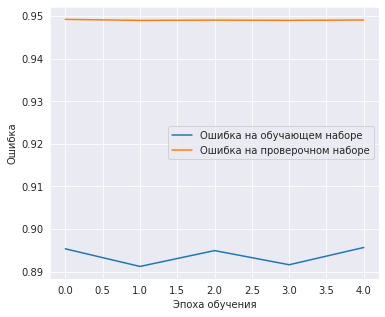

коэффициент корреляции проверочной последовательности- 0.5085788639317649
коэффициент корреляции обучающей последовательности - 0.4079554761571106


In [ ]:
# этот блок запускать не обязательно
history = modelC.fit(x_train_seq, 
                    y_train_seq, 
                    epochs=5,
                    verbose=2,
                    validation_data=(x_test_seq, y_test_seq))

# Строим график
plt.figure(figsize=(20,5))
plot_loss(history)

org = y_fit.inverse_transform(y_test_seq)
pr_scaled = y_fit.inverse_transform(modelC.predict(x_test_seq)).flatten()

#коэффициент корреляции
VAL = np.vstack((org, pr_scaled))
R_xy = np.corrcoef(VAL)
print('коэффициент корреляции проверочной последовательности-', R_xy[0][1])

org_tr = y_fit.inverse_transform(y_train_seq)
pr_tr_scaled = y_fit.inverse_transform(modelC.predict(x_train_seq)).flatten()

VAL = np.vstack((org_tr, pr_tr_scaled))
R_xy = np.corrcoef(VAL)
print('коэффициент корреляции обучающей последовательности -', R_xy[0][1])

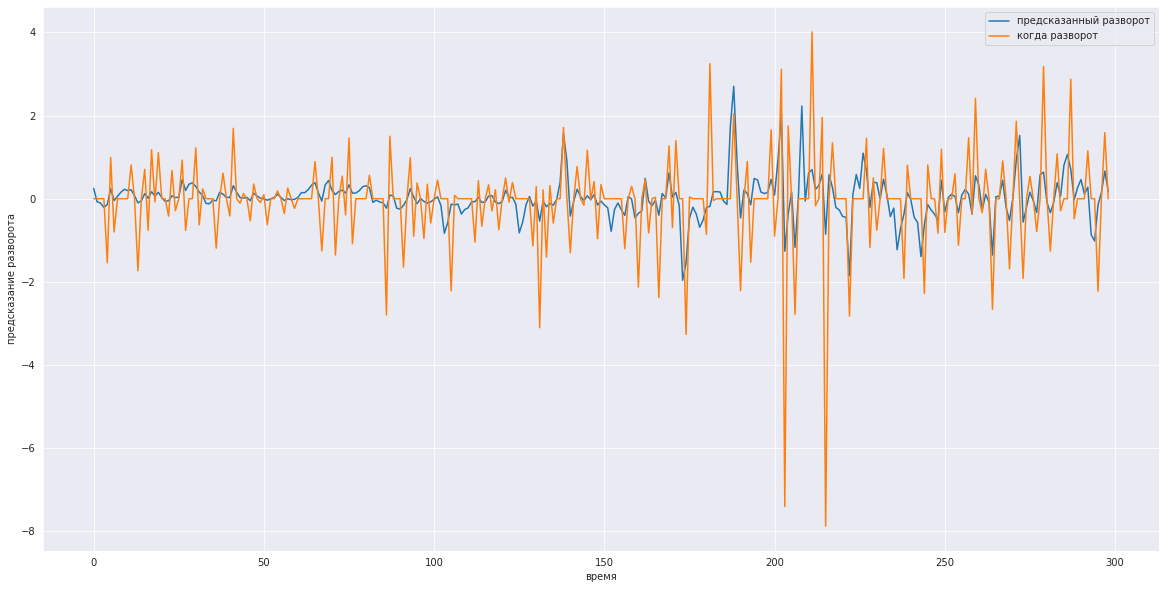

0.5086153198281952


In [ ]:
#визуально сравниваем предсказания на проверочной последовательности
a, b = 0, 300
plt.figure(figsize=(20,10))
plt.plot(pr_scaled[a:b], label='предсказанный разворот')
plt.plot(org[a:b], label='когда разворот')
plt.xlabel('время')
plt.ylabel('предсказание разворота')
plt.legend()
plt.show()

#коэффициент корреляции
VAL = np.vstack((org[a:b], pr_scaled[a:b]))
R_xy = np.corrcoef(VAL)
print(R_xy[0][1])

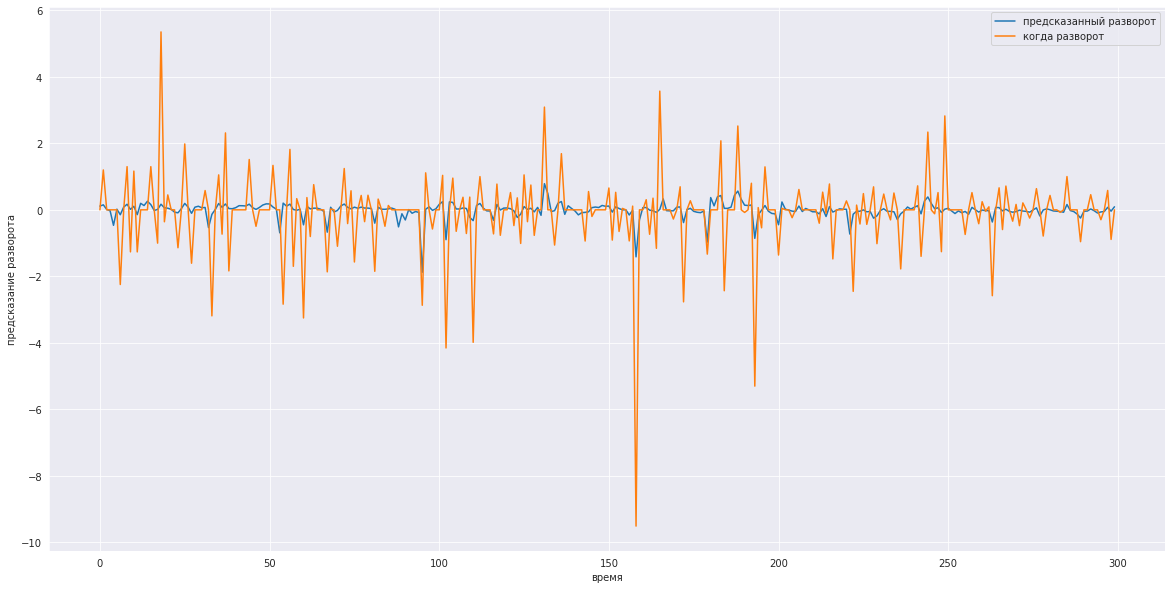

0.6164825209785574


In [ ]:
#визуально сравниваем предсказания на тренировочной последовательности
# org_tr = y_fit.inverse_transform(y_train_seq)
# pr_tr_scaled = y_fit.inverse_transform(modelC.predict(x_train_seq)).flatten()
a, b = 2100, 2400
plt.figure(figsize=(20,10))
plt.plot(pr_tr_scaled[a:b], label='предсказанный разворот')
plt.plot(org_tr[a:b], label='когда разворот')
plt.xlabel('время')
plt.ylabel('предсказание разворота')
plt.legend()
plt.show()

#коэффициент корреляции
VAL = np.vstack((org_tr[a:b], pr_tr_scaled[a:b]))
R_xy = np.corrcoef(VAL)
print(R_xy[0][1])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### **3. Подготовка данных для блока тестирования**

In [ ]:
#списки вероятностей для выбора сделки (на основе корреляции с шаблонами движения графика)
wsb_avrg, wsb_plus, wsb_minus = get_action_probability(pr_scaled, org) 
orig = np.append(org_tr, org)  #расчетные значения, обучающие + проверочные
pred = np.append(pr_tr_scaled, pr_scaled) #предсказанные значение, обучающие + проверочные

money_history = [100000] # здесь будет сохраняться статистика капитала

# + тюнинг шаблонов (на основе успешных экспериментов)
wsb_plus = [[6, 5, 2],
 [5, 3, 2],
 [5, 0, 3],
 [2, 0, 5],
 [0, 0, 3],
 [6, 0, 2],
 [4, 2, 4],
 [2, 2, 1],
 [4, 0, 5],
 [1, 2, 1],
 [10, 1, 6],
 [4, 8, 0]]

wsb_minus = [[1, 6, 1],
 [2, 4, 1],
 [14, 4, 9],
 [5, 3, 1],
 [10, 4, 2],
 [7, 2, 3],
 [9, 2, 1],
 [20, 21, 0],
 [13, 1, 2],
 [6, 3, 1],
 [10, 1, 13],
 [5, 7, 5]]

### **Блок тестирования модели**

1 Ждем 285.96063232421875
w [0, -1, -1] предск. [0.66413164 0.17090747 0.21252574]
------------------------
2 Ждем 288.23602294921875
w [0, 0, -1] предск. [0.17090747 0.21252574 0.03546406]
------------------------
3 Продали за 294.70599365234375
Денег: 100000.0
Акций: 0
s [1, 0, -1] предск. [ 0.21252574  0.03546406 -0.4130408 ]
------------------------
4 Ждем 299.60736083984375
w [0, -1, -1] предск. [ 0.03546406 -0.4130408  -0.51493686]
------------------------
5 Продали за 307.79998779296875
Денег: 100000.0
Акций: 0
s [1, 0, -1] предск. [-0.4130408  -0.51493686 -0.6014645 ]
------------------------
6 Ждем 307.98199462890625
w [0, 0, 1] предск. [-0.51493686 -0.6014645  -0.2644678 ]
------------------------
7 Купили по 304.9620056152344
Денег: 277.4241638183594
Акций: 327.0
b [-1, 0, 1] предск. [-0.6014645  -0.2644678  -0.09627512]
------------------------
8 Продали за 307.3999938964844
Денег: 100797.22216796875
Акций: 0
s [0, 1, 0] предск. [-0.2644678  -0.09627512 -0.26590216]
-------

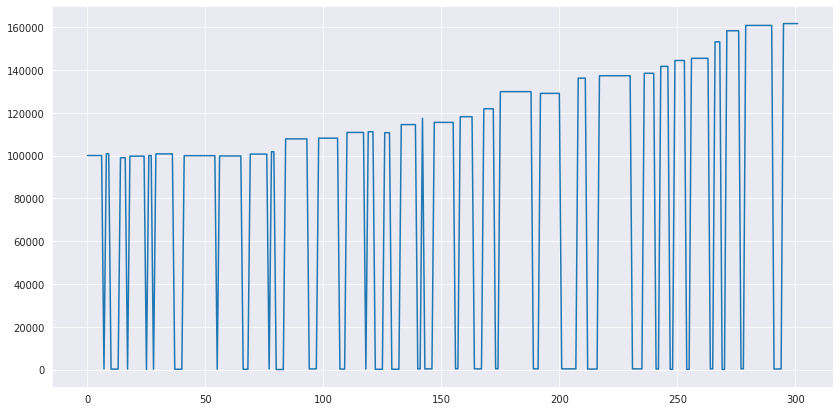

In [ ]:
# Ваша стратегия
money = 100000 # Стартовый капитал
shares = 0 # Стартовое количество акций
dataset = train_dataset.append(val_dataset).reset_index() # Объединяем обучающий и проверочный датасеты

# Проходим по всему тестовому датасету
for i in range(1, test_dataset.shape[0]+1):
  df = dataset.append(test_dataset[:i]).reset_index() # Считываем очередное значение из тестового датасета
  
  ############### стратегия #############
  tmp_df = df.iloc[-300:,1:] #берем исторический интервал + новое значение (чем больше интервал, тем меньше выбросов из-за масштабирования)
  tmp_x, tmp_y = get_sequence(tmp_df, xLen, x_fit, y_fit) #в x_fit д.б. StandartScale() тренировочной последовательности

  tmp_x, tmp_y = tmp_x[-1:], tmp_y[-1:] #вырезаем последнее окно

  tmp_pred = y_fit.inverse_transform(modelC.predict(tmp_x).flatten()) #текущее предсказание
  pred = np.append(pred, tmp_pred)  #добавляем в массив новое предсказанное значение

  action, m_id, avrg = act_predict(pred[-3:])
  # print(action)
  # Если должны покупать и есть деньги хотя бы на одну акцию
  if action == 'b' and money  > tmp_df.iloc[-1]['Close']:
    shares += money // tmp_df.iloc[-1]['Close'] # Покупаем на все имеющиеся деньги акции (покупаем целое количество (не обязательно))
    money = money % tmp_df.iloc[-1]['Close'] # Считаем сколько осталось денег после покупки акций
    # Выводим статистическую информацию
    print(i, 'Купили по', tmp_df.iloc[-1]['Close'])
    print('Денег:', money)
    print('Акций:', shares)
    print(action, matr[m_id], 'предск.', pred[-3:])
    print('------------------------')

  # Если должны продавать
  elif action == 's':
    money += shares * tmp_df.iloc[-1]['Close'] # Продаем все акции и увеличиваем капитал на заработанные деньги
    shares = 0  # Количество акцией сбрасываем в 0
    
    # Выводим статистическую информацию
    print(i, 'Продали за', df.iloc[-1]['Close'])
    print('Денег:', money)
    print('Акций:', shares)
    print(action, matr[m_id], 'предск.', pred[-3:])
    print('------------------------')  
  elif action == 'b':
    print(i, 'Пытались купить, но ждем', tmp_df.iloc[-1]['Close'])
    print(action, matr[m_id], 'предск.', pred[-3:])
    print('------------------------')  
  else:
    print(i, 'Ждем', tmp_df.iloc[-1]['Close'])
    print(action, matr[m_id], 'предск.', pred[-3:])
    print('------------------------')  
  money_history.append(money) # Записываем в статистику капитала текущее значение имеющихся денег

money += shares * tmp_df.iloc[-1]['Close'] # Продаем все акции и увеличиваем капитал на заработанные деньги
shares = 0 # Количество акцией сбрасываем в 0
money_history.append(money) # Записываем в статистику капитала текущее значение имеющихся денег
print('Продали ВСЕ')
print('Цена сделки:', df.iloc[-1]['Close'])
print('Денег:', money)
print('Акций:', shares)
# Выводим статистику изменения капитала
plt.figure(figsize=(14,7))
plt.plot(money_history)
plt.show()


In [ ]:
print('Финальный результат: ', round(money,2), 'руб.')

Финальный результат:  161656.77 руб.
